## Load Library

In [ ]:
import pycurl
from io import BytesIO
import bs4
from bs4 import BeautifulSoup
from bs4 import NavigableString
from tqdm import tqdm_notebook
from pandas import DataFrame
import pandas as pd
import os, sys
from time import sleep
import datetime

## Load Functions

In [ ]:
def search(url):
    buffer = BytesIO()
    storage = BytesIO()
    c = pycurl.Curl()
    c.setopt(c.URL, url)
    c.setopt(c.WRITEDATA, buffer)
    c.perform()
    c.close()
    body = buffer.getvalue()
    soup = BeautifulSoup(body, 'html.parser')
    return soup

def get_author_id(term, uni):
    term_up = term.upper()
    term_ref = term_up.replace(' ', '+')
    
    url = 'http://sinta2.ristekdikti.go.id/affiliations/detail?q='+ term_ref +'&search=1&view=authors&id='+uni
    author_search = search(url)
    
    for a in author_search.find_all('a', href=True):
        if term_up in a:
            url_id = (a['href'])
            auth_id = url_id.replace('/authors/detail/?id=', "")
            auth_idx = auth_id.replace('&view=overview', "")
    return auth_idx

def get_author_rank(auth_id1):
    url2 = 'http://sinta2.ristekdikti.go.id/authors/detail?id='+auth_id1+'&view=overview'
    info = search(url2)

    for a in info.find_all('div', class_='stat-lbl-big'):
        for i in a.contents:
            if "Rank in National" in i:
                x = a.find_previous('div', class_="stat-num")
                print('Rank in National '+x.contents[0])
            if "Rank in Affiliation" in i:
                x = a.find_previous('div', class_="stat-num")
                print('Rank in Affiliation '+x.contents[0])
            if " Score" in i:
                x = a.find_previous('div', class_="stat-num")
                print('SINTA Score '+x.contents[0])
            
    for a in info.find_all('div', class_='uk-width-2-10 uk-row-first stat-lbl-pub'):
        for i in a.contents:
            if "scopus" in i['src']:
                x = a.find_next('div', class_="uk-width-2-10 stat-num-pub")
                print('Scopus '+x.contents[0])
            if "scholar" in i['src']:
                x = a.find_next('div', class_="uk-width-2-10 stat-num-pub")
                print('Google Scholar '+x.contents[0])
    return

def get_author_info(term, uni):
    auth_id2 = get_author_id(term, uni)
    
    url2 = 'http://sinta2.ristekdikti.go.id/authors/detail?id='+auth_id2+'&view=overview'
    info = search(url2)
    
    for a in info.find_all('div', class_='stat-lbl-big'):
        for i in a.contents:
            if "Rank in National" in i:
                nr = a.find_previous('div', class_="stat-num")
                n_r = nr.contents[0]
            if "Rank in Affiliation" in i:
                ar = a.find_previous('div', class_="stat-num")
                a_r = ar.contents[0]
            if " Score" in i:
                ss = a.find_previous('div', class_="stat-num")
                s_s = ss.contents[0]
            
    for a in info.find_all('div', class_='uk-width-2-10 uk-row-first stat-lbl-pub'):
        for i in a.contents:
            if "scopus" in i['src']:
                s_a = a.find_next('div', class_="uk-width-2-10 stat-num-pub")
                s_c = s_a.find_next('div', class_="uk-width-2-10 stat-num-pub")
                s_i = s_c.find_next('div', class_="uk-width-2-10 stat-num-pub")
                sa = s_a.contents[0]
                sc = s_c.contents[0]
                si = s_i.contents[0]
            if "scholar" in i['src']:
                g_a = a.find_next('div', class_="uk-width-2-10 stat-num-pub")
                g_c = g_a.find_next('div', class_="uk-width-2-10 stat-num-pub")
                g_i = g_c.find_next('div', class_="uk-width-2-10 stat-num-pub")
                ga = g_a.contents[0]
                gc = g_c.contents[0]
                gi = g_i.contents[0]
    df_data = [term, auth_id2, n_r, a_r, s_s, si, gi, sa, sc, ga, gc]
    return df_data

def nidn(term, uni):
    term_up = term.upper()
    term_ref = term_up.replace(' ', '+')
    url = 'http://sinta2.ristekdikti.go.id/affiliations/detail?q='+ term_ref +'&search=1&view=authors&id='+uni
    author_search = search(url)
    for a in author_search.find_all('small'):
        if '/NIP/NIDK' in a.contents[0]:
            NIDN = a.next_sibling
            NIDN = NIDN.replace(' : ','')
    return NIDN

## Test

In [4]:
#Get SINTA ID
uni = '384'
term = 'Matin Nuhamunada'
author_id2 = get_author_id(term, uni)
author_id2

'6014421'

In [5]:
#Get HTML page of author's information based on SINTA ID
url2 = 'http://sinta2.ristekdikti.go.id/authors/detail?id='+author_id2+'&view=overview'
info = search(url2)
#info

In [6]:
#Create Empty Dataframe to contain data
df_data = DataFrame(columns=('Nama', \
                             "SINTA ID", \
                             "Rank National", \
                             "Rank Affiliation", \
                             "Sinta Score", \
                             "Scopus H-Index", \
                             "Google H-Index", \
                             "Scopus Art.", \
                             "Scopus Cit.", \
                             "Scholar Art.", \
                             "Scholar Cit." \
                            )
                    )
df_data.index.name = 'No'

In [7]:
#Test for multiple author search
biologi = {'Nama' : ["Matin Nuhamunada", "Indra Lesmana"]}
df_biologi = DataFrame(data=biologi)
df_biologi.index.name = 'No'
for i in tqdm_notebook(range(len(df_biologi))):
    df_data.loc[i] = get_author_info(df_biologi.loc[i, "Nama"], uni)
df_data

,Nama,SINTA ID,Rank National,Rank Affiliation,Sinta Score,Scopus H-Index,Google H-Index,Scopus Art.,Scopus Cit.,Scholar Art.,Scholar Cit.
No,,,,,,,,,,,
0,Matin Nuhamunada,6014421,11289,849,1.37,1,1,3,4,5,4
1,Indra Lesmana,6023357,23159,1208,0.29,0,0,2,0,3,0


## Data Mining of Lecturers from the Faculty of Biology UGM

In [8]:
lecturer = search('http://biologi.ugm.ac.id/en/lectures/')
#lecturer

In [9]:
lec_list = []
for i in lecturer.find_all('div', class_='elementor-tab-content elementor-clearfix'):
    for a in i.contents:
        for x in a.contents:
            if isinstance(x, NavigableString):
                pass
            else:
                #print(x.find_all('strong'))
                for b in x.find_all('strong'):#, href=True):
                    for c in b.contents:
                        if not isinstance(c, bs4.element.NavigableString):
                            if isinstance(c.contents[0], bs4.element.NavigableString):
                                d = c.contents[0]
                                lec_list.append(str(d))

In [10]:
lec_list = []
for i in lecturer.find_all('div', class_='elementor-tab-content elementor-clearfix'):
    for a in i.contents:
        for x in a.contents:
            if isinstance(x, NavigableString):
                pass
            else:
                #print(x.find_all('strong'))
                for b in x.find_all('strong'):#, href=True):
                    for c in b.contents:
                        if isinstance(c, bs4.element.NavigableString):
                            #print(c)
                            d = c
                            lec_list.append(str(d))
                        else:
                            if not isinstance(c, bs4.element.NavigableString):
                                if isinstance(c.contents[0], bs4.element.NavigableString):
                                    #print(c.contents[0])
                                    d = c.contents[0]
                                    lec_list.append(str(d))
#lec_list                                       

In [11]:
import re
replaced = [w.replace('Prof. Dr.\xa0', '')\
            .replace('Prof. Dr. ', '')\
            .replace('Prof. Dra. ', '')\
            .replace('Dr.rer.nat. ', '')\
            .replace('Dr. rer.nat. ', '')\
            .replace('Dr.biol.hom. ', '')\
            .replace('Dr.med.vet. ', '')\
            .replace('Dra. ', '')\
            .replace('Drs. ', '')\
            .replace('Dr. ', '')\
            .replace('Dr.\xa0', '')\
            .replace('S.S., ', '')\
            .replace(', ', '')\
            .replace('M.Sc.', '')\
            .replace('Ph.D.', '')\
            .replace('M.Si.', '')\
            .replace('M.Si', '')\
            .replace('M.S.', '')\
            .replace('M.App.Sc.', '')\
            .replace('S.Si. ', '')\
            .replace('S.Si.', '')\
            .replace('S.U.', '')\
            .replace('M.Biotech.', '')\
            .replace(' M.Env.Sc', '')\
            .replace('M.Agr.Sc.', '')\
            .replace('M. Eng.', '')\
            .replace('M.Agr.', '')\
            .replace('M.Kes.', '')\
            .replace('M.P.', '')\
            .replace('DAP', '')\
            .replace('MS.', '')\
            .replace('St.', '')\
            .replace('\xa0', '')\
            for w in lec_list]
#replaced

In [12]:
replaced2 = [w.replace('Niken Satuti Handayani', 'Niken Satuti Nur Handayani') \
             .replace('Ganies Riza A.', 'Ganies Riza Aristya') \
             .replace('L. Hartanto Nugroho', 'Laurentius Hartanto Nugroho') \
             .replace('Diah Rahmawati', 'Diah Rachmawati') \
             .replace('Rr. Upiek Ngesti W.A.', 'Rr Upiek Ngesti Wibawaning A') \
             .replace('Soenarwan Heri Poerwanto', 'Soenarwan Hery Poerwanto') \
             .replace('Dila Hening Windyarini', 'Dila Hening Windyaraini') \
             .replace('Susilo Hadi', 'Susilohadi') \
             .replace('Hendry T.S.S.G. Saragih', 'Hendry TSSG Saragih') \
             .replace('R.C. Hidayat Soesilohadi', 'R C Hidayat Soesilohadi') \
             .replace('Mulyati Sarto', 'Mulyati') \
             .replace('Slamet Widianto', 'Slamet Widiyanto') \
             .replace('Agnes Endang Sutariningsih', 'Agnes Endang Sutariningsih S') \
             .replace('.', '')\
             .replace(',', '')\
             for w in replaced]

In [13]:
biologi2 = {'Nama' : replaced2}
df_biologi2 = DataFrame(data=biologi2)
df_biologi2.index.name = 'No'
df_biologi3 = df_biologi2.drop([27])
df_biologi3.index = pd.RangeIndex(len(df_biologi3.index))
#df_biologi3

## Get SINTA Data from UGM Biology Lecturers

In [14]:

if not os.path.isfile('data3.csv'):
    df_data2 = DataFrame(columns=('Nama', \
                                  "SINTA ID", \
                                  "Rank National", \
                                  "Rank Affiliation", \
                                  "Sinta Score", \
                                  "Scopus H-Index", \
                                  "Google H-Index", \
                                  "Scopus Art.", \
                                  "Scopus Cit.", \
                                  "Scholar Art.", \
                                  "Scholar Cit." \
                                 )
                     
                        )
    df_data2.index.name = 'No'
else:
    df_data2 = pd.read_csv('data3.csv', index_col=0)
pbar = tqdm_notebook(range(len(df_biologi3))) #to make progressbar    
for i in pbar:
    if not i in df_data2.index:
        try:
            df_data2.loc[i] = get_author_info(df_biologi3.loc[i, "Nama"])
            pbar.set_description('processed: %d' % (i))
            pbar.update(1)
            sleep(1)
        except:
            print('error '+df_biologi3.loc[i, "Nama"])
            pass

In [15]:
#df_data2

In [16]:
df_data2.to_csv('data3.csv')

In [17]:
df_data3 = pd.read_csv('data3.csv', index_col=0)
rank_bio = df_data3.sort_values(by=['Rank National'], ascending=True)
rank_bio.index = pd.RangeIndex(len(rank_bio.index))+1
pd.options.display.max_rows = 70
rank_bio

,Nama,SINTA ID,Rank National,Rank Affiliation,Sinta Score,Scopus H-Index,Google H-Index,Scopus Art.,Scopus Cit.,Scholar Art.,Scholar Cit.
1,Endang Semiarti,5973460,121,10,47.51,6,9,24,759,164,1109
2,Nastiti Wijayanti,5972899,400,50,26.54,8,8,20,361,79,488
3,Yekti Asih Purwestri,21472,970,116,15.39,2,2,6,277,34,297
4,Budi Setiadi Daryono,21420,1153,136,13.59,3,7,32,31,296,257
5,Laurentius Hartanto Nugroho,5977709,1332,159,12.26,5,8,16,114,72,230
6,Rarastoeti Pratiwi,257321,2679,299,7.66,2,4,8,85,91,146
7,Maryani,6016534,2720,304,7.57,4,4,4,111,13,168
8,Eko Agus Suyono,42920,3381,367,6.20,3,4,17,21,50,43
9,Diah Rachmawati,6014449,3531,383,5.93,3,4,7,58,58,118
10,Rina Sri Kasiamdari,6003781,4349,450,4.76,2,4,7,33,78,99


## Data Mining NIDN to determine age

In [18]:
if not os.path.isfile('data_NIDN.csv'):
    df_data2 = DataFrame(columns=('Nama', \
                                  "NIDN", \
                                 )
                     
                        )
    df_data2.index.name = 'No'
else:
    df_data2 = pd.read_csv('data_NIDN.csv', index_col=0)
pbar = tqdm_notebook(range(len(df_biologi3))) #to make progressbar    
for i in pbar:
    if not i in df_data2.index:
        try:
            df_data2.loc[i] = [df_biologi3.loc[i, "Nama"], nidn(df_biologi3.loc[i, "Nama"])]
            pbar.set_description('processed: %d' % (i))
            pbar.update(1)
            sleep(1)
        except:
            print('error '+df_biologi3.loc[i, "Nama"])
            pass
        

In [19]:
#df_data2

In [20]:
df_data2.to_csv('data_NIDN.csv')

In [21]:
df_nidn = pd.read_csv('data_NIDN.csv', index_col=0)

In [22]:
df_nidn['NIDN'] = df_nidn['NIDN'].str.replace('o', '0')
df_nidn['NIDN'] = df_nidn['NIDN'].str.replace(' ', '')

In [26]:
df_age = DataFrame(columns=('DOB', \
                              "Age", \
                             )                   
                    )
df_age.index.name = 'No'

for i in range(len(df_nidn)):
    now = datetime.datetime.now()
    if not df_nidn.loc[i, 'NIDN'][:2] == '11':
        dob = '19' + df_nidn.loc[i, 'NIDN'][6:8]
        age = now.year - int(dob)
    else:
        dob = '1990'
        age = now.year - int(dob)
    df_age.loc[i] = [dob, age]

In [27]:
#df_age

In [28]:
result = pd.concat([df_data3, df_nidn['NIDN'], df_age], axis=1)
result.to_csv('result UGM.csv')
result

,Nama,SINTA ID,Rank National,Rank Affiliation,Sinta Score,Scopus H-Index,Google H-Index,Scopus Art.,Scopus Cit.,Scholar Art.,Scholar Cit.,NIDN,DOB,Age
No,,,,,,,,,,,,,,
0,Rarastoeti Pratiwi,257321,2679,299,7.66,2,4,8,85,91,146,0025106305,1963,55
1,Yekti Asih Purwestri,21472,970,116,15.39,2,2,6,277,34,297,0023057104,1971,47
2,Tri Rini Nuringtyas,21396,5198,510,3.92,3,5,7,29,36,79,0027037304,1973,45
3,Woro Anindito Sri Tunjung,6021239,4378,455,4.73,5,5,8,51,38,68,0520077903,1979,39
4,Lisna Hidayati,6002859,28119,1341,0.15,0,0,1,0,6,0,0021038604,1986,32
5,Endang Semiarti,5973460,121,10,47.51,6,9,24,759,164,1109,0023116204,1962,56
6,Ari Indrianto,6142358,62088,1853,0.00,0,0,0,0,0,0,0025115805,1958,60
7,Eko Agus Suyono,42920,3381,367,6.20,3,4,17,21,50,43,0018127101,1971,47
8,Aries Bagus Sasongko,6017558,38524,1527,0.04,0,2,0,0,8,4,0511038303,1983,35


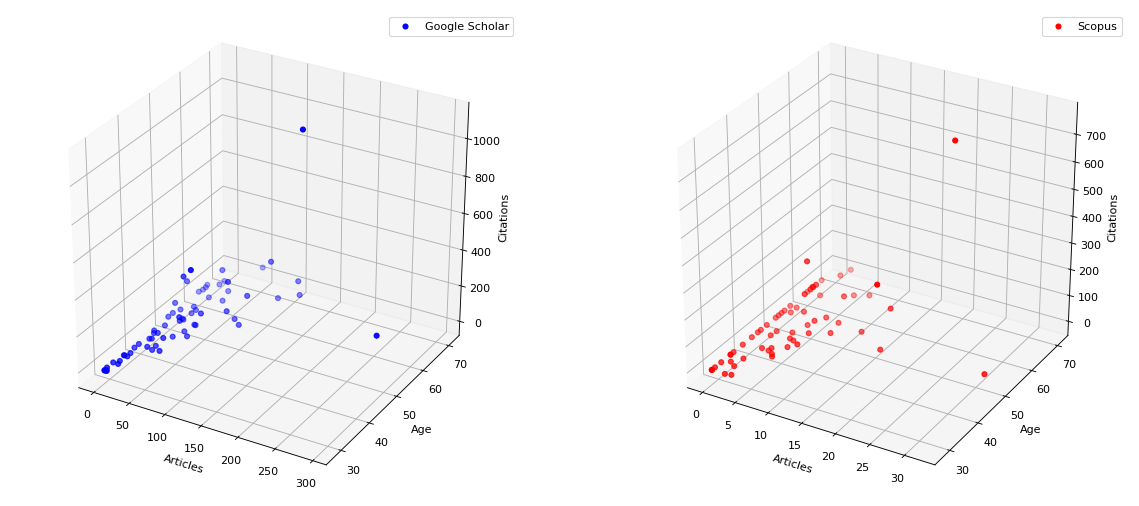

In [29]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')
#fig = plt.figure(figsize=plt.figaspect(0.5))
result = pd.read_csv('result UGM.csv', index_col=0)
ax = fig.add_subplot(1, 2, 1, projection='3d')
ys = result['Age'].values
xs = result['Scholar Art.'].values
zs = result['Scholar Cit.'].values
ax.scatter(xs, ys, zs, zdir='z', c='b', label='Google Scholar')
ax.legend()
ax.set_ylabel('Age')
ax.set_xlabel('Articles')
ax.set_zlabel('Citations')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ys = result['Age'].values
xs = result['Scopus Art.'].values
zs = result['Scopus Cit.'].values
ax.scatter(xs, ys, zs, zdir='z', c='r', label='Scopus')
ax.legend()
ax.set_ylabel('Age')
ax.set_xlabel('Articles')
ax.set_zlabel('Citations')


#plt.gca().invert_yaxis()
plt.show()

## Data Mining from Biology UB

In [30]:
#Get HTML page of author's information based on SINTA ID
url2 = 'https://biologi.ub.ac.id/s1.php'
info = search(url2)
#info

In [31]:
ls_NIP_UB = []
for i in info.find_all('a', href=True):
    for a in i:
        if isinstance(a, NavigableString):
            if a.isspace() == False:
                for b in a.find_next():
                    NIP = b.strip()
                    ls_NIP_UB.append(NIP)
NIP_UB = {'NIP' : ls_NIP_UB}
df_NIP_UB = DataFrame(data=NIP_UB)
df_NIP_UB

,NIP
0,195403111980021002
1,196308181988022001
2,196311271989032001
3,196806261997021001
4,196205281987012001
5,196309091988022001
6,196304141989032001
7,196111051990022001
8,197108081998021001
9,196302231988021001


In [32]:
ls = []
for i in info.find_all('a', href=True):
    for a in i:
        if isinstance(a, NavigableString):
            if a.isspace() == False:
                y = a.strip()
                ls.append(y)
ls = ls[:-1]
ls

['Prof. Sutiman Bambang Sumitro, SU.,D.Sc',
 'Prof.Dr.Ir. Estri Laras Arumingtyas, M.Sc.St',
 'Prof. Dra. Fatchiyah, M.Kes., Ph.D',
 'Prof. Muhaimin Rifa`i, S.Si., Ph.D.Med.Sc',
 'Dr. Sri Rahayu, M.Kes',
 'Dr. Serafinah Indriyani, M.Si',
 'Dr. Wahyu Widoretno, M.Si',
 'Dra. Nunung Harijati, MS.,Ph.D',
 'Luchman Hakim, S.Si.,M.Agr.Sc.,Ph.D',
 'Dr. Suharjono, MS',
 'Dr. Jati Batoro, M.Si',
 'Dr. Endang Arisoesilaningsih, MS',
 'Amin Setyo Leksono, S.Si.,M.Si.,Ph.D',
 'Dr.Ir. Moch. Sasmito Djati, MS',
 'Dr. Dra. Catur Retnaningdyah, M.Si',
 'Dr. Agung Pramana W.M., M.Si',
 'Prof. Widodo, S.Si.,M.Si.,Ph.D.Med.Sc',
 'Dr. Dra. Aminatun Munawarti, M.Si',
 'Ir. Retno Mastuti, M.Agr.Sc.,DAgr.Sc',
 'Dr. Sri Widyarti, M.Si',
 'Tri Ardyati, M.Agr., Ph.D',
 'Zulfaidah Penata Gama, S.Si., M.Si., Ph.D',
 'Nia Kurniawan, S.Si.,MP.,D.Sc',
 'Rodiyati Azrianingsih, S.Si.,M.Sc.,Ph.D',
 'Dra. Gustini Ekowati, M.Ling',
 'Dr. Bagyo Yanuwiadi',
 'Drs. Sofy Permana, M.Sc.,D.Sc',
 'Drs. Aris Soewondo, M.Si',
 '

In [33]:
import re
replaced = [w.replace('Prof. Dr.\xa0', '')\
            .replace('Prof.Dr.Ir. ', '')\
            .replace('Prof. Dr. ', '')\
            .replace('Prof. Dra. ', '')\
            .replace('Prof. ', '')\
            .replace('SU.,D.Sc', '')\
            .replace('Dr.rer.nat. ', '')\
            .replace('Dr. rer.nat. ', '')\
            .replace('Dr.biol.hom. ', '')\
            .replace('Dr.med.vet. ', '')\
            .replace('Dra. ', '')\
            .replace('Drs. ', '')\
            .replace('Dr.Ir. ', '')\
            .replace('Ir. ', '')\
            .replace('Dr. ', '')\
            .replace('Dr.\xa0', '')\
            .replace('S.S., ', '')\
            .replace(', ', '')\
            .replace('M.Sc.St', '')\
            .replace('M.Sc.', '')\
            .replace('M.Sc', '')\
            .replace('Ph.D.', '')\
            .replace('Ph.D', '')\
            .replace('M.Si., ', '')\
            .replace('M.Si.', '')\
            .replace('M.Si', '')\
            .replace('M.S.', '')\
            .replace('M.App.Sc.', '')\
            .replace('MP.,D.Sc', '')\
            .replace('D.Sc', '')\
            .replace('S.Si. ', '')\
            .replace('S.Si.', '')\
            .replace('S.U.', '')\
            .replace('M.Biotech.', '')\
            .replace(' M.Env.Sc', '')\
            .replace('M.Agr.Sc.', '')\
            .replace('M. Eng.', '')\
            .replace('M.Agr.', '')\
            .replace('M.Kes.', '')\
            .replace('Med.Sc', '')\
            .replace('M.Kes', '')\
            .replace('M.P.', '')\
            .replace('DAP', '')\
            .replace('MS.', '')\
            .replace('MS', '')\
            .replace('St.', '')\
            .replace('\xa0', '')\
            .replace('M.Ling', '')\
            .replace('DAgr.Sc', '')\
            .replace(',', '')\
            .replace('Moch.', 'Mochammad')\
            .replace('Rifa`i', "Rifa'i")\
            .replace('W.M.', "Warih Marhendra")\
            for w in ls]
replaced

['Sutiman Bambang Sumitro',
 'Estri Laras Arumingtyas',
 'Fatchiyah',
 "Muhaimin Rifa'i",
 'Sri Rahayu',
 'Serafinah Indriyani',
 'Wahyu Widoretno',
 'Nunung Harijati',
 'Luchman Hakim',
 'Suharjono',
 'Jati Batoro',
 'Endang Arisoesilaningsih',
 'Amin Setyo Leksono',
 'Mochammad Sasmito Djati',
 'Catur Retnaningdyah',
 'Agung Pramana Warih Marhendra',
 'Widodo',
 'Aminatun Munawarti',
 'Retno Mastuti',
 'Sri Widyarti',
 'Tri Ardyati',
 'Zulfaidah Penata Gama',
 'Nia Kurniawan',
 'Rodiyati Azrianingsih',
 'Gustini Ekowati',
 'Bagyo Yanuwiadi',
 'Sofy Permana',
 'Aris Soewondo',
 'Irfan Mustafa',
 'Brian Rahardi',
 'Muhamad Imam',
 'Dian Siswanto',
 'Yoga Dwi Jatmiko']

In [34]:
biologi_ub = {'Nama' : replaced}
df_biologi_ub2 = DataFrame(data=biologi_ub)
df_biologi_ub2.index.name = 'No'
#df_biologi_ub3 = df_biologi_ub2.drop([27])
#df_biologi_ub3.index = pd.RangeIndex(len(df_biologi_ub3.index))
df_biologi_ub2

,Nama
No,
0,Sutiman Bambang Sumitro
1,Estri Laras Arumingtyas
2,Fatchiyah
3,Muhaimin Rifa'i
4,Sri Rahayu
5,Serafinah Indriyani
6,Wahyu Widoretno
7,Nunung Harijati
8,Luchman Hakim


In [35]:
uni = '404'
if not os.path.isfile('data_NIDN_ub.csv'):
    df_data2 = DataFrame(columns=('Nama', \
                                  "NIDN", \
                                 )
                     
                        )
    df_data2.index.name = 'No'
else:
    df_data2 = pd.read_csv('data_NIDN_ub.csv', index_col=0)
pbar = tqdm_notebook(range(len(df_biologi_ub2))) #to make progressbar    
for i in pbar:
    if not i in df_data2.index:
        try:
            df_data2.loc[i] = [df_biologi_ub2.loc[i, "Nama"], nidn(df_biologi_ub2.loc[i, "Nama"], uni)]
            pbar.set_description('processed: %d' % (i))
            pbar.update(1)
            sleep(1)
        except:
            print('error '+df_biologi_ub2.loc[i, "Nama"])
            pass

df_nidn_ub = df_data2    

error Nunung Harijati
error Suharjono
error Jati Batoro
error Aminatun Munawarti
error Tri Ardyati
error Rodiyati Azrianingsih
error Gustini Ekowati
error Bagyo Yanuwiadi
error Aris Soewondo
error Muhamad Imam



In [36]:
df_nidn_ub

,Nama,NIDN
No,,
0,Sutiman Bambang Sumitro,11035404
1,Estri Laras Arumingtyas,18086306
2,Fatchiyah,27116307
3,Muhaimin Rifa'i,26066803
4,Sri Rahayu,28056206
5,Serafinah Indriyani,9096306
6,Wahyu Widoretno,14046307
8,Luchman Hakim,8087102
11,Endang Arisoesilaningsih,8095905


In [37]:
df_nidn_ub.to_csv('data_NIDN_ub.csv')

In [38]:

if not os.path.isfile('data4_ub.csv'):
    df_data2 = DataFrame(columns=('Nama', \
                                  "SINTA ID", \
                                  "Rank National", \
                                  "Rank Affiliation", \
                                  "Sinta Score", \
                                  "Scopus H-Index", \
                                  "Google H-Index", \
                                  "Scopus Art.", \
                                  "Scopus Cit.", \
                                  "Scholar Art.", \
                                  "Scholar Cit." \
                                 )
                     
                        )
    df_data2.index.name = 'No'
else:
    df_data2 = pd.read_csv('data4_ub.csv', index_col=0)
pbar = tqdm_notebook(df_nidn_ub.index.values) #to make progressbar    
for i in pbar:
    if not i in df_data2.index:
        #try:
            df_data2.loc[i] = get_author_info(df_nidn_ub.loc[i, "Nama"], '404')
            pbar.set_description('processed: %d' % (i))
            pbar.update(1)
            sleep(1)
        #except:
        #    print('error '+df_nidn_ub.loc[i, "Nama"])
        #    pass

In [39]:
df_sinta_ub = df_data2
df_sinta_ub.to_csv('data4_ub.csv')
df_sinta_ub

,Nama,SINTA ID,Rank National,Rank Affiliation,Sinta Score,Scopus H-Index,Google H-Index,Scopus Art.,Scopus Cit.,Scholar Art.,Scholar Cit.
No,,,,,,,,,,,
0,Sutiman Bambang Sumitro,5998175,543,13,22.44,5,8,38,127,100,255
1,Estri Laras Arumingtyas,5978827,7836,249,2.31,0,7,0,0,70,236
2,Fatchiyah,6137819,71660,1111,0.00,0,0,0,0,0,0
3,Muhaimin Rifa'i,6118973,126,3,47.20,9,12,32,696,119,1184
4,Sri Rahayu,5998293,14869,451,0.82,0,4,0,0,71,84
5,Serafinah Indriyani,5994014,14063,427,0.90,0,6,0,0,57,92
6,Wahyu Widoretno,6036949,7468,239,2.47,1,4,5,4,33,61
8,Luchman Hakim,6037433,2526,62,8.05,3,9,11,14,120,350
11,Endang Arisoesilaningsih,5998149,11879,370,1.23,0,6,0,0,75,125


In [40]:
df_age_ub = DataFrame(columns=('DOB', \
                              "Age", \
                             )                   
                    )
df_age_ub.index.name = 'No'

for i in df_sinta_ub.index.values:
    now = datetime.datetime.now()
    dob = str(df_NIP_UB.loc[i, 'NIP'])[:4]
    age = now.year - int(dob)
    df_age_ub.loc[i] = [dob, age]

In [41]:
df_age_ub

,DOB,Age
No,,
0,1954,64
1,1963,55
2,1963,55
3,1968,50
4,1962,56
5,1963,55
6,1963,55
8,1971,47
11,1959,59


In [42]:
x = pd.read_csv('data4_ub.csv', index_col=0)
result_ub = pd.concat([x, df_nidn_ub['NIDN'], df_age_ub], axis=1)
result_ub.to_csv('data UB.csv')
rank_bio_ub = result_ub.sort_values(by=['Rank National'], ascending=True)
rank_bio_ub.index = pd.RangeIndex(len(rank_bio_ub.index))+1
pd.options.display.max_rows = 70
rank_bio_ub

,Nama,SINTA ID,Rank National,Rank Affiliation,Sinta Score,Scopus H-Index,Google H-Index,Scopus Art.,Scopus Cit.,Scholar Art.,Scholar Cit.,NIDN,DOB,Age
1,Widodo,5982480,97,2,52.48,13,14,65,529,105,787,25046005,1973,45
2,Muhaimin Rifa'i,6118973,126,3,47.20,9,12,32,696,119,1184,26066803,1968,50
3,Sutiman Bambang Sumitro,5998175,543,13,22.44,5,8,38,127,100,255,11035404,1954,64
4,Amin Setyo Leksono,5984023,2047,48,9.67,1,8,15,5,108,268,171172003,1972,46
5,Luchman Hakim,6037433,2526,62,8.05,3,9,11,14,120,350,8087102,1971,47
6,Mochammad Sasmito Djati,6036875,2724,66,7.57,4,6,15,30,76,127,4036106,1961,57
7,Wahyu Widoretno,6036949,7468,239,2.47,1,4,5,4,33,61,14046307,1963,55
8,Estri Laras Arumingtyas,5978827,7836,249,2.31,0,7,0,0,70,236,18086306,1963,55
9,Dian Siswanto,5996481,9332,289,1.79,2,4,4,12,25,25,20037703,1977,41
10,Agung Pramana Warih Marhendra,6144044,9829,306,1.67,1,2,4,1,5,6,16066507,1965,53


## Data Lecture SITH ITB

In [43]:
#Get HTML page of author's information based on SINTA ID
url2 = 'https://sith.itb.ac.id/en/staf-dosen/'
info = search(url2)
#info

In [44]:
lec_ITB_raw = []
for a in info.select("a[href^=mailto:]"):
    x = a.previous_element
    y = x.find_previous()
    for z in y:
        lec_ITB_raw.append(z)

In [45]:
#lec_ITB_raw

In [46]:
import re
replaced = [w.replace('Dr. ', '')\
            .replace('Dr.', '')\
            .replace('Dr ', '')\
            .replace('Prof.', '')\
            .replace('Prof', '')\
            .replace('Ir.', '')\
            .replace('MP. ', '')\
            .replace('MP.', '')\
            .replace('MP', '')\
            .replace('S.Si.,', '')\
            .replace('S.Si,', '')\
            .replace('S. Si.,', '')\
            .replace('M.Si. ', '')\
            .replace('M.Si.', '')\
            .replace('M.Si', '')\
            .replace('M.Sc.', '')\
            .replace('M.Sc', '')\
            .replace('ST.', '')\
            .replace('S.T.', '')\
            .replace('MT.', '')\
            .replace('M.T.', '')\
            .replace('SP.', '')\
            .replace('S.P.', '')\
            .replace('S.Hut.', '')\
            .replace('Ph.D.', '')\
            .replace('Ph.D', '')\
            .replace('PhD.', '')\
            .replace('Eng.', '')\
            .replace('M.Agr.', '')\
            .replace('BA.', '')\
            .replace('Dr', '')\
            .replace(', ', '')\
            .replace('M., ', 'Muhammad')\
            for w in lec_ITB_raw]
lec_ITB = []
for i in replaced:
    lec_ITB.append(i.rstrip())
#lec_ITB

In [47]:
SITH_ITB = {'Nama' : lec_ITB}
df_sith = DataFrame(data=SITH_ITB)
df_sith.index.name = 'No'
#df_biologi_ub3 = df_biologi_ub2.drop([27])
#df_biologi_ub3.index = pd.RangeIndex(len(df_biologi_ub3.index))
df_sith

,Nama
No,
0,Sastia Prama Putri
1,Robert Manurung
2,M. Yusuf Abduh
3,Asep Hidayat
4,Aos
5,Ujang Dinar Husyari
6,Ahim Ruswandi
7,Rika Alfianny
8,Rijanti Rahayu Maulani


In [48]:
uni = '379'
if not os.path.isfile('data_NIDN_ITB.csv'):
    df_data2 = DataFrame(columns=('Nama', \
                                  "NIDN", \
                                 )
                     
                        )
    df_data2.index.name = 'No'
else:
    df_data2 = pd.read_csv('data_NIDN_ITB.csv', index_col=0)
pbar = tqdm_notebook(range(len(df_sith))) #to make progressbar    
for i in pbar:
    if not i in df_data2.index:
        try:
            df_data2.loc[i] = [df_sith.loc[i, "Nama"], nidn(df_sith.loc[i, "Nama"], uni)]
            pbar.set_description('processed: %d' % (i))
            pbar.update(1)
            sleep(1)
        except:
            print('error '+df_sith.loc[i, "Nama"])
            pass

df_nidn_sith = df_data2    

error Sastia Prama Putri
error M. Yusuf Abduh
error Rijanti Rahayu Maulani
error Annisa Ratna Nurillah
error Khairul Hadi Burhan
error Pingkan Aditiawati
error Kamarisima
error Amalia Ghaisani Komarudin
error Tati Suryati Syamsudin,
error Aditya Dimas Pramudya
error Deti Nurdianti Kuswatiningsih
error Husna Nugrahapraja
error Ima Mulyama Zainuddin
error Karlia Meitha
error Achmad Sjarmidi
error Endang Hernawan
error Sri Nanan B. Widiyanto
error Rizkita Rachhmi Esyanti
error Taufikurahman
error Andira Rahmawati
error Novi Tri Astutiningsih
error Rudi Dungani
error Asep Suhaeri
error Noviana Budianti



In [50]:
df_nidn_sith.to_csv('data_NIDN_ITB.csv')
df_nidn_sith

,Nama,NIDN
No,,
1,Robert Manurung,3125401.0
3,Asep Hidayat,401066606.0
4,Aos,13116704.0
5,Ujang Dinar Husyari,18076806.0
6,Ahim Ruswandi,3067006.0
7,Rika Alfianny,403046601.0
9,Aep Supriyadi,9016101.0
10,Rizki Fauziah Ramadhaini,11068502.0
11,Chindy Ulima Zanetta,28078903.0


In [51]:
if not os.path.isfile('data4_sith.csv'):
    df_data2 = DataFrame(columns=('Nama', \
                                  "SINTA ID", \
                                  "Rank National", \
                                  "Rank Affiliation", \
                                  "Sinta Score", \
                                  "Scopus H-Index", \
                                  "Google H-Index", \
                                  "Scopus Art.", \
                                  "Scopus Cit.", \
                                  "Scholar Art.", \
                                  "Scholar Cit." \
                                 )
                     
                        )
    df_data2.index.name = 'No'
else:
    df_data2 = pd.read_csv('data4_sith.csv', index_col=0)
pbar = tqdm_notebook(df_nidn_sith.index.values) #to make progressbar    
for i in pbar:
    if not i in df_data2.index:
        try:
            df_data2.loc[i] = get_author_info(df_nidn_sith.loc[i, "Nama"], '379')
            pbar.set_description('processed: %d' % (i))
            pbar.update(1)
            sleep(1)
        except:
            print('error '+df_nidn_sith.loc[i, "Nama"])
            pass

error Isty Adhitya
error Maelita Ramdani
error Wawan Gunawan



In [52]:
df_data2.to_csv('data4_sith.csv')
df_data2

,Nama,SINTA ID,Rank National,Rank Affiliation,Sinta Score,Scopus H-Index,Google H-Index,Scopus Art.,Scopus Cit.,Scholar Art.,Scholar Cit.
No,,,,,,,,,,,
1,Robert Manurung,6036454,272,49,33.36,10,14,21,463,60,759
3,Asep Hidayat,6035214,12106,717,1.20,0,6,0,0,22,122
4,Aos,6032302,25296,897,0.20,0,3,0,0,17,20
5,Ujang Dinar Husyari,6035394,103070,1123,0.00,0,0,0,0,2,0
6,Ahim Ruswandi,6035348,49339,1002,0.01,0,1,0,0,1,1
7,Rika Alfianny,6035377,93905,1110,0.00,0,0,0,0,1,0
9,Aep Supriyadi,6035303,58590,1036,0.00,0,0,0,0,1,0
10,Rizki Fauziah Ramadhaini,6032277,36962,962,0.05,0,2,0,0,3,5
11,Chindy Ulima Zanetta,6007337,12451,725,1.14,1,3,3,7,14,18


In [53]:
df_age = DataFrame(columns=('DOB', \
                              "Age", \
                             )                   
                    )
df_age.index.name = 'No'

for i in df_data2.index.values:
    now = datetime.datetime.now()
    dob = '19' + str(df_nidn_sith.loc[i, 'NIDN'])[-6:-4]
    age = now.year - int(dob)
    if age >= 70:
        dob = '1990'
        age = now.year - int(dob)
    df_age.loc[i] = [dob, age]

In [54]:
df_age

,DOB,Age
No,,
1,1954,64
3,1966,52
4,1967,51
5,1968,50
6,1970,48
7,1966,52
9,1961,57
10,1985,33
11,1989,29


In [55]:
result_sith2 = pd.concat([df_data2, df_age], axis=1)
result_sith2.to_csv('result SITH.csv')
result_sith2["Rank National"] = pd.to_numeric(result_sith2["Rank National"])
type(result_sith2.loc[1, 'Rank Affiliation'])

numpy.int64

## Visualization

In [56]:
rank_bio_sith = result_sith2.sort_values(by=['Rank National'], ascending=True)
rank_bio_sith.index = pd.RangeIndex(len(rank_bio_sith.index))+1
pd.options.display.max_rows = 80
rank_bio_sith

,Nama,SINTA ID,Rank National,Rank Affiliation,Sinta Score,Scopus H-Index,Google H-Index,Scopus Art.,Scopus Cit.,Scholar Art.,Scholar Cit.,DOB,Age
1,Djoko Tjahjono Iskandar,5986603,46,11,65.64,19,27,44,1514,133,3366,1950,68
2,Robert Manurung,6036454,272,49,33.36,10,14,21,463,60,759,1954,64
3,Gede Suantika,6042207,444,70,25.25,8,9,22,300,57,546,1970,48
4,Intan Ahmad,18586,955,132,15.65,4,47,10,49,2203,11950,1990,28
5,I Nyoman Pugeg Aryantha,5980933,1109,152,14.02,5,8,18,111,71,341,1965,53
6,Anggraini Barlian,6041538,1196,160,13.34,4,5,10,179,20,245,1963,55
7,Anne Hadiyane,6033805,1352,181,12.14,6,5,9,172,8,190,1971,47
8,Devi Nandita Choesin,6042202,1626,209,10.68,4,5,11,127,34,241,1961,57
9,Ahmad Faizal,5982429,1668,214,10.50,6,6,11,119,21,180,1981,37
10,Adi Pancoro,6034881,1787,226,10.03,2,6,19,17,87,330,1959,59


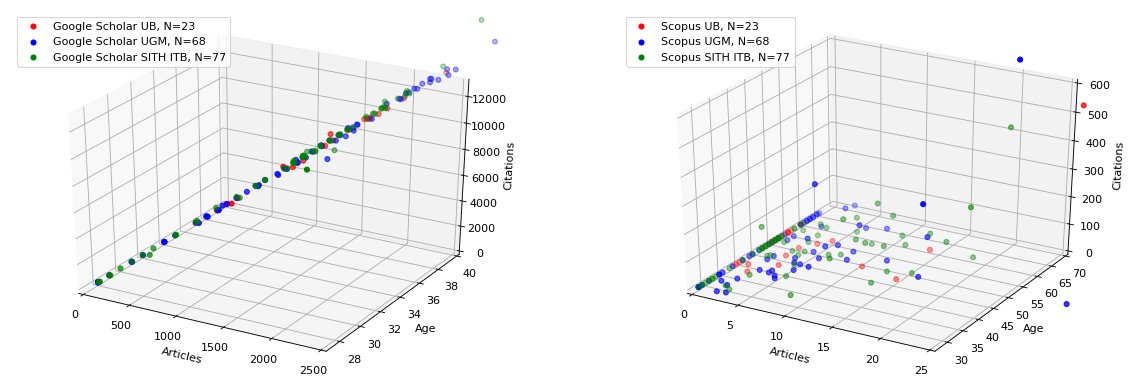

In [57]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
#fig = plt.figure(figsize=plt.figaspect(0.5))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')

result_ub = pd.read_csv('data UB.csv')
N_UB = len(result_ub.index)
lab_UB = 'UB, N=' + str(N_UB)
ys = result_ub['Age'].values
xs = result_ub['Scholar Art.'].values
zs = result_ub['Scholar Cit.'].values
ax1.scatter(xs, ys, zs, zdir='z', c='r', label='Google Scholar '+lab_UB)

result = pd.read_csv('result UGM.csv', index_col=0)
N_UGM = len(result.index)
lab_UGM = 'UGM, N=' + str(N_UGM)
ys1 = result['Age'].values
xs1 = result['Scholar Art.'].values
zs1 = result['Scholar Cit.'].values
ax1.scatter(xs1, ys1, zs1, zdir='z', c='b', label='Google Scholar '+lab_UGM)

result_sith = pd.read_csv('result SITH.csv', index_col=0)
N_sith = len(result_sith2.index)
lab_sith = 'SITH ITB, N=' + str(N_sith)
ys2 = result_sith['Age'].values
xs2 = result_sith['Scholar Art.'].values
zs2 = result_sith['Scholar Cit.'].values
ax1.scatter(xs2, ys2, zs2, zdir='z', c='g', label='Google Scholar '+lab_sith)

#ax1.set_xscale('semilog')
ax1.legend()
ax1.set_ylabel('Age')
ax1.set_xlabel('Articles')
ax1.set_zlabel('Citations')
ax1.set_xlim3d(0, 2500)
ax1.set_ylim3d(27, 40)
ax1.set_zlim3d(0, 13000)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ys = result_ub['Age'].values
xs = result_ub['Scopus Art.'].values
zs = result_ub['Scopus Cit.'].values
ax2.scatter(xs, ys, zs, zdir='z', c='r', label='Scopus '+lab_UB)

ys2 = result['Age'].values
xs2 = result['Scopus Art.'].values
zs2 = result['Scopus Cit.'].values
ax2.scatter(xs2, ys2, zs2, zdir='z', c='b', label='Scopus '+lab_UGM)

ys3 = result_sith['Age'].values
xs3 = result_sith['Scopus Art.'].values
zs3 = result_sith['Scopus Cit.'].values
ax2.scatter(xs3, ys3, zs3, zdir='z', c='g', label='Scopus '+lab_sith)

#ax2.set_xscale('semilog')
ax2.legend()
ax2.set_xlim3d(0, 25)
ax2.set_ylim3d(27, 70)
ax2.set_zlim3d(0, 600)
ax2.set_ylabel('Age')
ax2.set_xlabel('Articles')
ax2.set_zlabel('Citations')

plt.show()

In [67]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

print (__version__) # requires version >= 1.9.0

2.7.0


In [4]:
import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np

result = pd.read_csv("result UGM_2.csv", index_col=0)
result_sith = pd.read_csv("result SITH.csv", index_col=0)

age, art, cit = result_sith['Age'].values, result_sith['Scopus Art.'].values, result_sith['Scopus Cit.'].values
trace1 = go.Scatter3d(
    x=age,
    y=art,
    z=cit,
    mode='markers',
    text=result_sith['Nama'].values,
    marker=dict(
        color='red',
        size=8,
        line=dict(
            color='gray',
            width=0.8
        ),
        opacity=0.5
    )
)

x2, y2, z2 = result['Age'].values, result['Scopus Art.'].values, result['Scopus Cit.'].values
trace2 = go.Scatter3d(
    x=x2,
    y=y2,
    z=z2,
    mode='markers',
    text=result['Nama'].values,
    marker=dict(
        color='blue',
        size=8,
        symbol='circle',
        line=dict(
            color='gray',
            width=1
        ),
        opacity=0.5
    )
)
data = [trace1, trace2]
layout = go.Layout(scene = dict(
                    xaxis = dict(
                        title='Age'),
                    yaxis = dict(
                        title='Articles'),
                    zaxis = dict(
                        title='Citation'),),
                    #width=700,
                    margin=dict(
                    r=0, b=0,
                    l=0, t=0)
                  )
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='data')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~matin_nuhamunada/0 or inside your plot.ly account where it is named 'data'
